# FURN-E Lite

FURN-E Lite based on FURN-E, the "Open Source" category winner of the 2023 AEC Hackathon in NYC.

FURN-E Lite takes your generative AI image scene (from Midjourney, DALL-E, etc.) and automatically returns cropped images around each furniture object in the scene. It can also automatically search the web for similar products that you can buy or catalog for furniture, fixtures and equipment (FF&E) procurement later in your project.

## Step 0: Upload your generative AI image to Google Drive

Upload the image to Google Drive in whatever folder you want.

## Step 1: Edit file and folder paths

After you upload the image to Google Drive you'll need to update the `img_file_path` in the code below. You may also want to edit `img_results_dir` in the code below to specify where on Google Drive you want cropped images saved.

### Input Generative AI Image File Path

ALWAYS start the file path with `/content/drive/MyDrive/`

In [ ]:
# File Path of the generative AI image

img_file_path = '/content/drive/MyDrive/img_00.png'

### Folder where cropped images will go

ALWAYS start the folder path with `/content/drive/MyDrive/`

ALWAYS end the folder path with `/`

In [ ]:
# Folder where cropped images and links are stored
# Note: If using with Google Drive, always start the file path with
# '/content/drive/MyDrive/'

img_results_dir = '/content/drive/MyDrive/'

### Websites selling products of interest

Sites for product vendors/manufacturers you want to search with text descriptions of each architectural element/object recognized in the image.

When adding and removing websites to the list below, always make sure websites are separated by commas and are wrapped in single quotes

Good: `['google.com', 'dell.com']`

Bad: `['google.com', dell.com]` dell.com not wrapped in single quotes

Bad: `['google.com' 'dell.com']` websites not separated by commas

In [ ]:
sites = ['ikea.com', 'bernieandphyls.com', 'hermanmiller.com', 'target.com', 'steelcase.com']

## Step 2: Run all!

OK let's go! After you specify the file path of the generative AI image in `img_file_path` and `img_results_dir` in the code above, look at the **top menu bar ("File Edit...")**

Click the **"Runtime"** dropdown menu, and then click **"Run all"**!

The rest of the code below will run automatically, but feel free to read through the rest of the notebook to learn the steps.

All cropped images will be saved to the Google Drive folder you specified above. At the very bottom of this notebook, you'll also see some product links paired with the cropped images.

# Step 3: Mount your Google Drive

In order for Google Colab to access your files on Google Drive you need to "mount" the drive. The code right below just links or connects to notebook to the files in your Google Drive.

Without this step, this Google Colab notebook won't find your image!

In [3]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 4: Install Code Libraries

Beyond what's already in Google Colab, you'll need to download and install some additional code libraries.

Couple things:

 - This is not downloading things to your computer. This is downloading to the filesystem of Google Colab
 - The next time you open this notebook in Google Colab, you may need to install these.

In [21]:
# Install transformers library for HuggingFace image-to-text description models

In [1]:
!pip install transformers

In [ ]:
# Install packages for automatically Googling text descriptions

In [2]:
!pip install beautifulsoup4
!pip install google

## Step 5: Import relevant coding libraries

Now all coding libraries have been installed, but Google Colab notebook still needs to know which libraries it will use in the context of this notebook.

In [4]:
import torch
import os
from PIL import Image
import json
import pandas as pd
from IPython.display import display

from transformers import ViltProcessor, ViltForQuestionAnswering

import random
from googlesearch import search

## Step 6: Show the generative AI image

In [8]:
# Open the image and display it below
image = Image.open(img_file_path)

# First make sure this image is processed as an RGB image
# if it isn't convert it to an RGB image
if image.mode != "RGB":
  image = image.convert(mode="RGB")

display(image)

Output hidden; open in https://colab.research.google.com to view.

## Step 7: Load the Object Recognition Model

In [9]:
# Object Recognition Model
# YOLOv5: https://github.com/ultralytics/yolov5
obj_rec_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-11-5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [10]:
# Object Recognition Classes
# specfic to the YOLOv5 object recognition model and COCO Dataset
class_dict = {
        56: "chair",
        57: "couch",
        59: "bed",
        60: "dining table",
        61: "toilet",
        62: "tv",
        68: "microwave",
        69: "oven",
        71: "sink",
        72: "refrigerator",
        74: "clock"
        }

# Store keys as a list
# these numbers are what YOLOv5 ultimately uses to recognize
# objects in the image
classes = [key for key in class_dict.keys()]

# Tell object recognition model to only look for the kinds of
# objects specified above in class_dict
obj_rec_model.classes = classes

## Step 8: Recognize Objects in the Image

The function code below will detect relevant objects in the image.

In [11]:
def rec_obj(img_file_path):
  """
  given a file path to a specific image,
  return a Dataframe that lists the objects recognized
  and x,y coordinates of the bounding box around each object
  in that image.

  Args:
  img_file_path (str): file path of the image you want objects recognized

  Returns:
  results_img: Image with objects recognized with labels and bounding boxes
  results_df: Dataframe of objects and bounding box coordinates around objects
  """
  results = obj_rec_model(img_file_path)
  results_df = results.pandas().xyxy[0]
  return results, results_df

In [12]:
img_objs, img_objs_df = rec_obj(img_file_path)
img_objs.show()

Output hidden; open in https://colab.research.google.com to view.

The image you see above should have bounding boxes around some architectural elements, labels, and a number between 0 and 1, which represents the confidence of the object recognition model for that particular object's label.

## Step 9: Generate cropped images for each recognized object

Using the bounding box

In [13]:
def get_cropped_imgs(img, img_file_path, img_results_dir):
  """
  given a specific image, identify objects within that image and
  save cropped images based on the bounding box of each object recognized.

  Args:
  img (Image object):
  img_file_path (str): file path of the image you want objects recognized

  Returns:
  class_list (list): A list of labels for each recognized object in the image
  cropped_images_files (list): List of file paths for each cropped image
  """
  img_objs, croppings_df = rec_obj(img_file_path)

  class_list = list(croppings_df['name'])

  cropped_images_files = []

  for index, row in croppings_df.iterrows():
      # Define the coordinates for the crop (left, upper, right, lower)
      left, upper, right, lower = row['xmin'], row['ymin'], row['xmax'], row['ymax']

      # Crop the image using slices
      cropped_image = img.crop((left, upper, right, lower))

      # Display or save the cropped image

      class_name = row['name']
      cropped_file_name = os.path.join(img_results_dir, f'{index}_{class_name}.png')

      cropped_image.save(cropped_file_name)

      cropped_images_files.append(cropped_file_name)
  return class_list, cropped_images_files

In [14]:
# After this runs, check your Google Drive for the cropped images
class_list, cropped_images_files = get_cropped_imgs(image, img_file_path, img_results_dir)

## Recommended: Google's Search by Image

You should now see a few cropped images in your `img_results_dir` folder.

For best results, you can just stop here and use Google Image search using your cropped images and Google's "Search by image" functionality.

## Step 10: Generate Text Description for Cropped Images

Continue with generating text descriptions for each cropped image

In [15]:
# Use ViltForQuestionAnswering model from HuggingFace
# https://huggingface.co/dandelin/vilt-b32-finetuned-vqa

img2text_processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
img2text_model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")


In [16]:
def get_text_description(img, class_name):
  if img.mode != "RGB":
    img = img.convert(mode="RGB")

  attributes = ['style', 'color', 'material']
  description = []
  for attr in attributes:
      # prepare image + question
      text = f"Describe the {class_name} {attr}"

      # prepare inputs
      encoding = img2text_processor(img, text, return_tensors="pt")

      # forward pass
      outputs = img2text_model(**encoding)
      logits = outputs.logits
      idx = logits.argmax(-1).item()
      description.append(img2text_model.config.id2label[idx])

  description.append(class_name)

  description = " ".join(description)
  return description

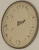

In [17]:
# Open the first cropped image and display it below
cropped_image = Image.open(cropped_images_files[0]) #change 0 to whatever index of image file you want

# First make sure this image is processed as an RGB image
# if it isn't convert it to an RGB image
if cropped_image.mode != "RGB":
  cropped_image = cropped_image.convert(mode="RGB")

display(cropped_image)

In [18]:
# Get a text description of the first cropped image for text-based search
get_text_description(cropped_image, class_list[0])

'modern white wood clock'

## Final Step: Display image-product link pairings

The code below goes through each cropped image, generates a text description, and uses that text description to search through all sites in `sites` you listed at the top of this notebook.

The final output shows each image, the text description, and a random link from among the results of each search query of each site listed at the top of this notebook.

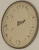

modern white wood clock
https://www.ikea.com/eg/en/p/dekad-alarm-clock-low-voltage-white-70540482/
https://store.hermanmiller.com/decor-wall-decor-clocks?lang=en_US
https://www.target.com/s/oversized+white+wall+clock
https://www.steelcase.com/resources/documents/storage-spec-guide
====



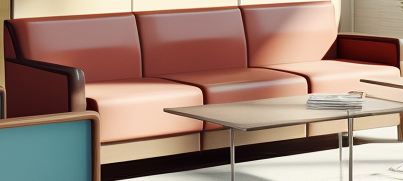

modern orange leather couch
https://www.ikea.com/us/en/cat/sofas-sectionals-fu003/
https://www.bernieandphyls.com/sitemap.xml
https://www.hermanmiller.com/products/seating/lounge-seating/clyde-sofa/
https://www.target.com/s/orange+loveseat
https://www.steelcase.com/eu-en/resources/documents/orangebox-coze-datacard/
====



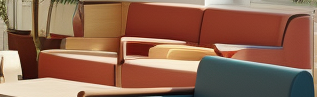

modern red leather couch
https://www.ikea.com/at/en/cat/sofas-fu003/f/red-sofa-co007/?page=3
https://www.bernieandphyls.com/living-room-furniture/sofas.html
https://store.hermanmiller.com/living-room-furniture-sofas-sectionals/luva-modular-sofa/2560901.html?lang=en_US
https://www.target.com/c/sofas-couches-living-room-furniture/christopher-knight-home/-/N-5xtm1Z4yhzt
https://www.steelcase.com/content/uploads/2019/05/coalesseseatingoutdoor.pdf
====



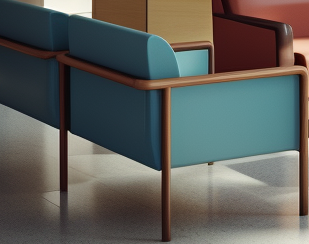

modern blue leather chair
https://www.ikea.com/us/en/cat/chairs-fu002/f/blue-chairs-co006/?page=3
https://www.bernieandphyls.com/living-room-furniture/recliners.html
https://store.hermanmiller.com/living-room-furniture-lounge-chairs-ottomans/nelson-coconut-chair/975.html?lang=en_US
https://www.target.com/p/set-of-2-laslo-modern-upholstered-faux-leather-dining-chairs-navy-blue-saracina-home/-/A-79581666
https://store.steelcase.com/seating/high-performance-seating/leap?cartId=599ff44c-f103-4ea0-9ffb-23936d4c1dbc&cclcl=en_US&yoReviewsPage=4
====



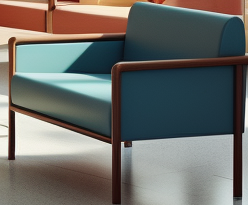

modern blue leather couch
https://www.ikea.com/us/en/cat/sofa-modules-31786/
https://www.bernieandphyls.com/living-room-furniture/sofas.html
https://store.hermanmiller.com/living-room-furniture-sofas-sectionals/lispenard-sofa/2197621.html?lang=en_US
https://www.target.com/s/blue+tufted+sofa
https://www.steelcase.com/content/uploads/2022/04/2022_SC_Partners_QuickShip_Catalog.pdf
====



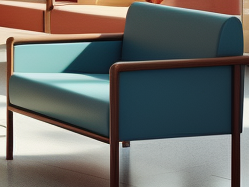

modern blue leather chair
https://www.ikea.com/us/en/cat/chairs-fu002/f/leather-chairs-ma039/
https://www.bernieandphyls.com/furniture-brands/furniture-sunbrella-fabrics/furniture-sunbrella-fabrics-chairs.html
https://store.hermanmiller.com/living-room-furniture-lounge-chairs-ottomans?lang=en_US
https://www.target.com/p/set-of-2-laslo-modern-upholstered-faux-leather-dining-chairs-navy-blue-saracina-home/-/A-79581666
https://www.steelcase.com/products/lounge-chairs/mono-lounge-chair/
====



In [20]:
# For each cropped image
for i, img_file in enumerate(cropped_images_files):

  # Open cropped image
  cropped_image = Image.open(img_file) #change 0 to whatever index of image file you want

  # First make sure this image is processed as an RGB image
  # if it isn't convert it to an RGB image
  if cropped_image.mode != "RGB":
    cropped_image = cropped_image.convert(mode="RGB")

  # Show the displayed image
  display(cropped_image)

  # Generate the text description for the cropped image
  product_description = get_text_description(cropped_image, class_list[i])

  # Show the generated text description
  print(product_description)

  # For each site listed at the top of the notebook
  for site in sites:
    # Construct the search query with the specific website and product description
    query = f'site:{site} {product_description}'

    # Get a list of 10 search results from Google and stop after getting 10 results
    results = list(search(query, tld="co.in", num=10, stop=10))

    # If there's at least one search result
    if len(results) > 0:
      # show a random link from among the search results
      random_number = random.randint(0, len(results)-1)
      print(results[random_number])

  print('====')
  print()

# Team Zombies

The entire FURN-E project is brought to you by Team Zombies:

Jaxon Fortune, Pablo Herraiz, Dan Lu, Mona Mirzaie, Sophie Moore, Christopher Smith, Benjamin Zuill-Smith